Place for a picture

# Logistic Regression of Chcago Car Crash Data

## Business Problem/Question

Can we use factors from this dataset that are trackable by an insurance company to determining whether a private passenger vehicle crash in Chicago incurs property damage over $1,500 and can we make good predictions using these factors? 

## EDA

In [1]:
# Importing packages
import numpy as np
import pandas as pd 
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

### Read in and create new csv

In [395]:
# Read in data

df_vehicles = pd.read_csv("Data\Traffic_Crashes_-_Vehicles_20231109.csv", parse_dates=["CRASH_DATE"], low_memory=False)
df_people = pd.read_csv("Data\Traffic_Crashes_-_People_20231109.csv", parse_dates=["CRASH_DATE"], low_memory=False)
df_crashes = pd.read_csv("Data\Traffic_Crashes_-_Crashes_20231109.csv", parse_dates=["CRASH_DATE"], low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\Traffic_Crashes_-_Vehicles_20231109.csv'

In [ ]:
# Filter out any data from before 2021

df_crashes = df_crashes[df_crashes["CRASH_DATE"].dt.year >= 2021]
df_people = df_people[df_people["CRASH_DATE"].dt.year >= 2021]
df_vehicles = df_vehicles[df_vehicles["CRASH_DATE"].dt.year >= 2021]

Using the data dictionaries to understand column names, we are dropping columns from each set that are not relevant to the business problem.

In [ ]:
# Drop columns from Vehicles dataframe

df_vehicles.drop(columns = ['UNIT_NO', 'LIC_PLATE_STATE', 'TRAVEL_DIRECTION', 'MANEUVER',
                            'TOWED_I', 'FIRE_I', 'TOWED_BY', 'TOWED_TO', 'AREA_00_I', 
                            'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 
                            'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 
                            'AREA_11_I', 'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT', 'CMV_ID', 
                            'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR', 
                            'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY',
                            'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO', 'HAZMAT_PRESENT_I', 
                            'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I',
                            'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 
                            'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 
                            'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH',
                            'AXLE_CNT', 'VEHICLE_CONFIG', 'CARGO_BODY_TYPE', 'LOAD_TYPE',
                            'HAZMAT_OUT_OF_SERVICE_I', 'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS'],
                            inplace=True)

In [ ]:
# Drop columns from People dataframe

df_people.drop(columns = ['PERSON_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SAFETY_EQUIPMENT', 
                          'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL', 
                          'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION',
                          'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE'], inplace=True)

In [ ]:
# Drop columns from Crashes dataframe

df_crashes.drop(columns = ['CRASH_DATE_EST_I', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                           'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 
                           'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'FIRST_CRASH_TYPE', 'LANE_CNT', 
                           'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 
                           'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 
                           'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 
                           'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 
                           'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 
                           'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_MONTH', 
                           'LATITUDE', 'LONGITUDE', 'LOCATION'], inplace=True) 

Because we are most interested in vehicle damage, we are using the Vehicles dataframe as the main and merging the others into it.

In [ ]:
# Merge People dataframe with Vehicles dataframe

df = df_vehicles.merge(df_people, how="left", on=["CRASH_RECORD_ID", "CRASH_DATE", "RD_NO", "VEHICLE_ID"])

In [ ]:
# Merge Crashes dataframe with merged dataframe

df = pd.merge(df, df_crashes, how = 'inner', on = ['CRASH_RECORD_ID', "CRASH_DATE", "RD_NO"])

In [ ]:
# Exporting new dataframe to csv for use throughout rest of notebook

df.to_csv("Data\chicago_traffic_accidents_2021_to_11-09-2023.csv")

### Working with a single merge dataset

In [3]:
# Can load merged dataframe without needing to go through above steps each time

df = pd.read_csv("Data\chicago_traffic_accidents_2021_to_11-09-2023.zip", 
                 parse_dates=["CRASH_DATE"], low_memory=False)

We don't need all the identifying columns as they are not useful in making a model. We will drop all of those now.

In [4]:
df.drop(columns = ["Unnamed: 0", "CRASH_UNIT_ID", "CRASH_RECORD_ID", 
                   "RD_NO", "VEHICLE_ID"], inplace=True)

We only want unique vehicle damage count, so we need to remove rows that represent passengers, as these will duplicate the vehicle damage. We also should remove any other rows that don't represent drivers. We can use the "PERSON_TYPE" column for this.

In [5]:
# Check values in Person_type column

df['PERSON_TYPE'].value_counts(normalize=True)

DRIVER                 0.780694
PASSENGER              0.197756
PEDESTRIAN             0.012899
BICYCLE                0.007730
NON-MOTOR VEHICLE      0.000760
NON-CONTACT VEHICLE    0.000162
Name: PERSON_TYPE, dtype: float64

In [6]:
# Remove all types of person except DRIVER

df = df[df['PERSON_TYPE'] == 'DRIVER']

In [7]:
# Sanity check

df['PERSON_TYPE'].value_counts(normalize=True)

DRIVER    1.0
Name: PERSON_TYPE, dtype: float64

### Missingness

Next we look at null values to try to determine which columns might need to be imputed or if the data is too incomplete to be useful. 

In [8]:
# First dropping columns that no longer have any data after removing all but DRIVER entries

df= df.dropna(axis=1, how="all")

In [9]:
# Looking at the total nulls left in remaining columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530319 entries, 0 to 766594
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_DATE               530319 non-null  datetime64[ns]
 1   UNIT_TYPE                530310 non-null  object        
 2   NUM_PASSENGERS           85079 non-null   float64       
 3   CMRC_VEH_I               10945 non-null   object        
 4   MAKE                     530098 non-null  object        
 5   MODEL                    530098 non-null  object        
 6   VEHICLE_YEAR             434488 non-null  float64       
 7   VEHICLE_DEFECT           530098 non-null  object        
 8   VEHICLE_TYPE             530098 non-null  object        
 9   VEHICLE_USE              530098 non-null  object        
 10  OCCUPANT_CNT             530098 non-null  float64       
 11  EXCEED_SPEED_LIMIT_I     9 non-null       object        
 12  PERSON_TYPE     

There are several columns that seem useful from the data dictionaries, but look almost entirely full of nulls. We do a value_counts for those columns to see what's in them.

In [10]:
# NUM_PASSENGERS

df["NUM_PASSENGERS"].value_counts(dropna=False)

NaN     445240
1.0      60610
2.0      15374
3.0       6037
4.0       2034
5.0        560
6.0        234
7.0         84
8.0         28
10.0        23
9.0         19
11.0        18
12.0        10
17.0         6
14.0         5
19.0         4
13.0         4
16.0         4
15.0         3
18.0         2
22.0         2
21.0         2
27.0         2
43.0         2
26.0         2
20.0         1
33.0         1
34.0         1
28.0         1
46.0         1
42.0         1
30.0         1
32.0         1
31.0         1
24.0         1
Name: NUM_PASSENGERS, dtype: int64

There is no 0 value, so the NaNs are problably 0. However, OCCUPANT_CNT represents the same information so we won't need this column. 

In [11]:
# CMRC_VEH_I

df["CMRC_VEH_I"].value_counts(dropna=False)

NaN    519374
Y        6602
N        4343
Name: CMRC_VEH_I, dtype: int64

This is a binary flag, but the missing values represent the overwhelming majority. We can drop the Y rows because they are commercial vehicles and do not fit the business problem, but the rest we will leave as we cannot make an assumption from such a small subset that the Y/N ratio is representative of the whole. 

In [12]:
# Dropping Commercial Vehicles

df = df[df["CMRC_VEH_I"]!="Y"]

In [13]:
# Sanity Check

df["CMRC_VEH_I"].value_counts(dropna=False)

NaN    519374
N        4343
Name: CMRC_VEH_I, dtype: int64

In [14]:
# EXCEED_SPEED_LIMIT_I

df["EXCEED_SPEED_LIMIT_I"].value_counts(dropna=False)

NaN    523708
N           5
Y           4
Name: EXCEED_SPEED_LIMIT_I, dtype: int64

This is a binary flag, but the missing values represent the overwhelming majority. We cannot make an assumption from such a small subset that the Y/N ratio is representative of the whole. This does not seem to be a useful column.

In [15]:
# AGE

df["AGE"].value_counts(dropna=False, normalize=True)

NaN      0.290504
28.0     0.020503
27.0     0.020442
29.0     0.020274
26.0     0.020207
           ...   
101.0    0.000010
102.0    0.000008
103.0    0.000006
98.0     0.000006
110.0    0.000004
Name: AGE, Length: 106, dtype: float64

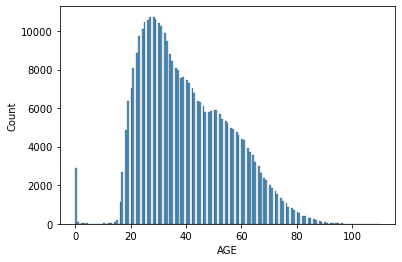

In [16]:
sns.histplot(df["AGE"]);

Missing values is a relatively large percentage of the whole at about 29%. There are many ages labeled 0, which may be another indicator of missingness. Also there are ages below the legal driving age of 15 which would not be included in an insurable class of people. We will drop ages unknown or below 15.

In [17]:
# Removing ages that could not drive legally or are unknown
df=df[df["AGE"]>14]

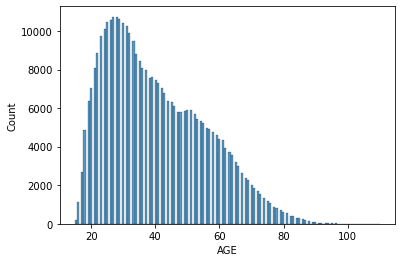

In [18]:
sns.histplot(df["AGE"]);

In [19]:
# CELL_PHONE_USE

df["CELL_PHONE_USE"].value_counts(dropna=False)

NaN    368278
N           1
Name: CELL_PHONE_USE, dtype: int64

This is a binary flag, but the missing values represent the overwhelming majority. We cannot make an assumption from such a small subset that the Y/N ratio is representative of the whole. This does not seem to be a useful column.

In [20]:
# Dropping all columns determined not to be useful

df.drop(columns = ["CMRC_VEH_I", "EXCEED_SPEED_LIMIT_I", "CELL_PHONE_USE"], inplace=True)

In [21]:
#Sanity Check

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368279 entries, 0 to 766594
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_DATE               368279 non-null  datetime64[ns]
 1   UNIT_TYPE                368277 non-null  object        
 2   NUM_PASSENGERS           72153 non-null   float64       
 3   MAKE                     368169 non-null  object        
 4   MODEL                    368169 non-null  object        
 5   VEHICLE_YEAR             353179 non-null  float64       
 6   VEHICLE_DEFECT           368169 non-null  object        
 7   VEHICLE_TYPE             368169 non-null  object        
 8   VEHICLE_USE              368169 non-null  object        
 9   OCCUPANT_CNT             368169 non-null  float64       
 10  PERSON_TYPE              368279 non-null  object        
 11  SEX                      368279 non-null  object        
 12  AGE             

### Compare Variables

In [241]:
# Check out the rest of the variables for weirdness

df.describe(include="all")

<ipython-input-241-b1800870b00c>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include="all")


,CRASH_DATE,UNIT_TYPE,NUM_PASSENGERS,MAKE,MODEL,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,OCCUPANT_CNT,...,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK,IN_STATE,DRIVING_SKILLS,TIME_OF_DAY,DAMAGE_OVER_1500
count,115208,115208,22451.000000,115208,115208,115208.000000,115208,115208,115208,115208.000000,...,115208,115208,115208,115208.000000,115208.000000,115208.000000,110529.000000,115208.000000,115208,115208.000000
unique,84168,1,NaN,9,327,NaN,15,5,1,NaN,...,3,38,38,NaN,NaN,NaN,NaN,NaN,3,NaN
top,2021-01-06 13:00:00,DRIVER,NaN,TOYOTA,OTHER (EXPLAIN IN NARRATIVE),NaN,NONE,PASSENGER,PERSONAL,NaN,...,"OVER $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,Daytime,NaN
freq,13,115208,NaN,21408,6117,NaN,72002,86154,115208,NaN,...,57604,37007,46705,NaN,NaN,NaN,NaN,NaN,45208,NaN
first,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-11-09 02:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.437753,NaN,NaN,2013.488091,NaN,NaN,NaN,1.279981,...,NaN,NaN,NaN,1256.270893,13.560968,4.154121,0.937528,0.061063,NaN,0.500000
std,NaN,NaN,0.812480,NaN,NaN,5.677537,NaN,NaN,NaN,0.672731,...,NaN,NaN,NaN,701.180587,5.253989,1.973061,0.242012,0.239448,NaN,0.500002
min,NaN,NaN,1.000000,NaN,NaN,1998.000000,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,111.000000,0.000000,1.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,1.000000,NaN,NaN,2010.000000,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,731.000000,10.000000,2.000000,1.000000,0.000000,NaN,0.000000


Look at VEHICLE_YEAR because max is 9999.

In [23]:
# First we'll see how many vehicles have vehicle years that are not possible

future_cars = df[df["VEHICLE_YEAR"] > 2024]
future_cars["VEHICLE_YEAR"].count()

185

In [24]:
# See if anything else is apparent about these rows

future_cars.head()

,CRASH_DATE,UNIT_TYPE,NUM_PASSENGERS,MAKE,MODEL,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,OCCUPANT_CNT,...,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK
773,2023-04-24 14:13:00,DRIVER,NaN,ACURA,ILX,2032.0,UNKNOWN,PASSENGER,PERSONAL,1.0,...,F,46.0,NaN,D,"OVER $1,500",IMPROPER TURNING/NO SIGNAL,NOT APPLICABLE,123.0,14,2
1823,2023-08-18 16:00:00,DRIVER,NaN,HONDA,HR-V,2108.0,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,1.0,...,F,41.0,NaN,NaN,"$501 - $1,500",NOT APPLICABLE,NOT APPLICABLE,922.0,16,6
14367,2023-05-04 18:58:00,DRIVER,NaN,HONDA,ODYSSEY,2100.0,UNKNOWN,VAN/MINI-VAN,PERSONAL,1.0,...,F,48.0,IL,D,"OVER $1,500",DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,NOT APPLICABLE,632.0,18,5
15356,2023-05-05 15:00:00,DRIVER,NaN,GENERAL MOTORS CORPORATION (GMC),SAVANNAH,3009.0,UNKNOWN,PASSENGER,PERSONAL,1.0,...,M,64.0,IL,NaN,"$501 - $1,500",FOLLOWING TOO CLOSELY,FOLLOWING TOO CLOSELY,1621.0,15,6
16494,2023-05-06 08:17:00,DRIVER,NaN,CHEVROLET,TRUCK,2066.0,NONE,PICKUP,PERSONAL,1.0,...,M,17.0,IL,D,"OVER $1,500",FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,824.0,8,7


In [25]:
# Percent of rows with future VEHICLE_YEARS

len(future_cars)/len(df)*100

0.0502336543761659

In [26]:
# Nothing seems apparently off about these vehicles, 
# but as they are such a small percentage we will drop them out

df = df[df["VEHICLE_YEAR"] <= 2024]

In [27]:
# Looking at the first years now

df["VEHICLE_YEAR"].value_counts().sort_index()

1900.0       10
1901.0        2
1902.0        1
1929.0        1
1939.0        1
          ...  
2020.0    21306
2021.0    16804
2022.0    10193
2023.0     4279
2024.0      282
Name: VEHICLE_YEAR, Length: 71, dtype: int64

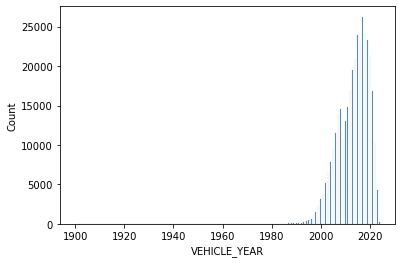

In [28]:
sns.histplot(df["VEHICLE_YEAR"]);

Anything over 25 years is considered a classic and can be insured as such. As most of the data falls within the last 25 years and anything older can be treated as a different insurance type, we will only use the last 25 years of data.

In [242]:
# Keeping only vehicles 25 years and newer

df=df[df["VEHICLE_YEAR"]>1997]

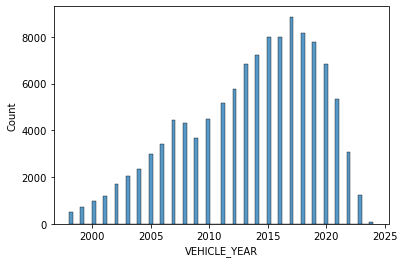

In [243]:
sns.histplot(df["VEHICLE_YEAR"]);

Looking at the rest of the columns.

In [31]:
df["VEHICLE_TYPE"].value_counts()

PASSENGER                                 239545
SPORT UTILITY VEHICLE (SUV)                57002
VAN/MINI-VAN                               15435
PICKUP                                     12229
UNKNOWN/NA                                  5829
TRUCK - SINGLE UNIT                         5595
BUS OVER 15 PASS.                           3983
OTHER                                       3857
TRACTOR W/ SEMI-TRAILER                     1908
BUS UP TO 15 PASS.                          1468
MOTORCYCLE (OVER 150CC)                      995
SINGLE UNIT TRUCK WITH TRAILER               497
OTHER VEHICLE WITH TRAILER                   448
TRACTOR W/O SEMI-TRAILER                     295
MOPED OR MOTORIZED BICYCLE                   129
AUTOCYCLE                                     21
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          21
ALL-TERRAIN VEHICLE (ATV)                     16
FARM EQUIPMENT                                12
RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)         1
Name: VEHICLE_TYPE, 

We're not interested in all these vehicle types, so we will remove everything that is explicitly not a passenger vehicle.

In [32]:
keep_vehicle = ["PASSENGER", "PICKUP", 
                "SPORT UTILITY VEHICLE (SUV)", 
                "UNKNOWN/NA", "VAN/MINI-VAN"]

In [33]:
df = df[df["VEHICLE_TYPE"].isin(keep_vehicle)]

In [34]:
# Sanity check

df["VEHICLE_TYPE"].value_counts()

PASSENGER                      239545
SPORT UTILITY VEHICLE (SUV)     57002
VAN/MINI-VAN                    15435
PICKUP                          12229
UNKNOWN/NA                       5829
Name: VEHICLE_TYPE, dtype: int64

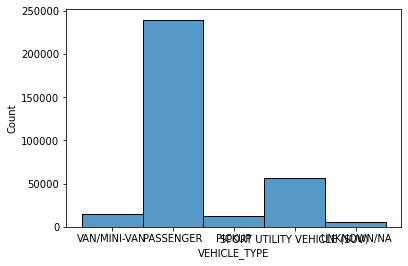

In [35]:
sns.histplot(df["VEHICLE_TYPE"]);

It seems too lopsided to use in model, but it was useful to filter out Vehicle Types that do not fit the business problem. 

In [36]:
df["VEHICLE_USE"].value_counts(dropna=False)

PERSONAL                    282460
UNKNOWN/NA                   28345
OTHER                         6754
RIDESHARE SERVICE             3116
TAXI/FOR HIRE                 2669
POLICE                        2066
NOT IN USE                    1617
COMMERCIAL - SINGLE UNIT       932
CONSTRUCTION/MAINTENANCE       819
DRIVER EDUCATION               317
STATE OWNED                    165
TOW TRUCK                      157
AMBULANCE                      148
CTA                            132
COMMERCIAL - MULTI-UNIT        132
FIRE                            74
LAWN CARE/LANDSCAPING           65
SCHOOL BUS                      39
AGRICULTURE                     14
MILITARY                         9
CAMPER/RV - SINGLE UNIT          8
HOUSE TRAILER                    2
Name: VEHICLE_USE, dtype: int64

We only want personal vehicles, so we will remove the rest.

In [37]:
df = df[df["VEHICLE_USE"]=="PERSONAL"]

In [38]:
df["CRASH_DATE"].value_counts(dropna=False)

2021-02-04 14:00:00    20
2021-11-19 15:30:00    19
2022-02-17 17:00:00    19
2022-10-25 17:30:00    18
2021-12-10 16:00:00    18
                       ..
2023-06-30 20:12:00     1
2021-11-14 10:07:00     1
2022-11-01 06:45:00     1
2023-05-24 18:50:00     1
2022-06-18 10:25:00     1
Name: CRASH_DATE, Length: 150871, dtype: int64

We are not doing a time analysis, so this will not be used in our model. 

In [39]:
df["UNIT_TYPE"].value_counts(dropna=False)

DRIVER    282460
Name: UNIT_TYPE, dtype: int64

This corresponds to PERSON_TYPE. We will not use either in our model as it was used to filter the data.

In [40]:
df["MAKE"].value_counts(dropna=False)

TOYOTA                                                   37325
CHEVROLET                                                35512
NISSAN                                                   27359
HONDA                                                    26949
FORD                                                     25064
                                                         ...  
FLEETWOOD ENTERPRISES                                        1
MORGAN EQUIPMENT COMPANY                                     1
DODD MANUFACTURING COMPANY, INC.                             1
UTILIMASTER (DIVISION OF HOLIDAY RAMBLER CORPORATION)        1
PICK-UP MANUFACTURING                                        1
Name: MAKE, Length: 136, dtype: int64

In [41]:
# 
topnine=["TOYOTA", "CHEVROLET", "NISSAN", "HONDA", "FORD", "JEEP", "HYUNDAI", "DODGE", "KIA"]
df= df[df["MAKE"].isin(topnine)]

This could be useful in our model. We will probably filter for top makes if we do use it.

In [42]:
df["MODEL"].value_counts(dropna=False)

OTHER (EXPLAIN IN NARRATIVE)    10709
CAMRY                            9953
COROLLA                          7432
CIVIC                            7033
ALTIMA                           6924
                                ...  
STYLE LINE                          1
J-10                                1
LANCER                              1
KA                                  1
COBRA                               1
Name: MODEL, Length: 349, dtype: int64

This could be useful. We may use it with MAKE and determine after filtering for top makes. Will need to avoid multicollinearity.

In [43]:
df["VEHICLE_DEFECT"].value_counts(dropna=False)

NONE                125758
UNKNOWN              77008
BRAKES                 864
OTHER                  829
TIRES                  171
STEERING               168
WHEELS                  84
SUSPENSION              61
ENGINE/MOTOR            46
FUEL SYSTEM             23
WINDOWS                 11
LIGHTS                   9
SIGNALS                  5
CARGO                    5
EXHAUST                  3
RESTRAINT SYSTEM         1
Name: VEHICLE_DEFECT, dtype: int64

Lot of UNKNOWN. Possibly useful, but even if we bin between NONE and all other variables the data would still be lopsided. Will not use in model.

In [44]:
df["OCCUPANT_CNT"].value_counts(dropna=False, normalize=True)

1.0     0.797109
2.0     0.142890
3.0     0.038352
4.0     0.014948
5.0     0.004926
6.0     0.001195
7.0     0.000463
8.0     0.000088
9.0     0.000020
11.0    0.000005
10.0    0.000005
Name: OCCUPANT_CNT, dtype: float64

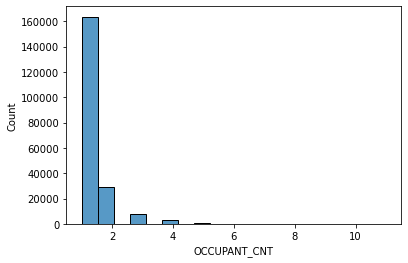

In [45]:
sns.histplot(df["OCCUPANT_CNT"]);

Could bin into HAS_PASSENGER but harder to track and implement for stakeholder. Would still be pretty lopsided. 

In [46]:
df["SEX"].value_counts(dropna=False, normalize=True)

M    0.547931
F    0.451089
X    0.000980
Name: SEX, dtype: float64

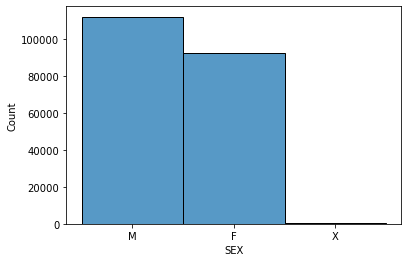

In [47]:
sns.histplot(df["SEX"]);

X is a small percentage and represents an unknown. We may drop later.

In [48]:
df["DRIVERS_LICENSE_STATE"].value_counts(dropna=False)

IL     184325
NaN      8663
IN       3207
WI        997
MI        697
        ...  
OA          1
VI          1
CW          1
BH          1
SX          1
Name: DRIVERS_LICENSE_STATE, Length: 149, dtype: int64

Bin for in state and out of state. 

In [49]:
df["DRIVERS_LICENSE_CLASS"].value_counts(dropna=False, normalize=True)

D      0.735635
NaN    0.203803
C      0.017747
A      0.013851
B      0.009076
         ...   
CC     0.000005
PS     0.000005
DE     0.000005
XX     0.000005
CQ     0.000005
Name: DRIVERS_LICENSE_CLASS, Length: 132, dtype: float64

Data is lopsided and contains a fair bit missing.

In [50]:
df["BEAT_OF_OCCURRENCE"].value_counts(dropna=False, normalize=True)

813.0     0.012007
815.0     0.010481
833.0     0.010183
114.0     0.009778
1834.0    0.009105
            ...   
1125.0    0.000839
1653.0    0.000605
1655.0    0.000527
1652.0    0.000263
1650.0    0.000141
Name: BEAT_OF_OCCURRENCE, Length: 275, dtype: float64

Data not easily useable by stakeholder. May be useful for future projects.

In [51]:
df["CRASH_HOUR"].value_counts(dropna=False, normalize=True)

15    0.085883
16    0.084415
17    0.080299
14    0.068399
18    0.065166
13    0.060577
12    0.057060
8     0.053417
11    0.049238
19    0.046351
7     0.042747
10    0.042576
9     0.041800
20    0.037343
21    0.032466
22    0.028862
23    0.025697
6     0.018708
0     0.018640
1     0.015933
2     0.013456
5     0.011675
3     0.010115
4     0.009178
Name: CRASH_HOUR, dtype: float64

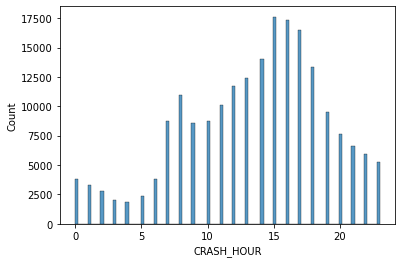

In [52]:
sns.histplot(df["CRASH_HOUR"]);

Bin to times of day.

In [53]:
df["CRASH_DAY_OF_WEEK"].value_counts(dropna=False, normalize=True)

6    0.166392
7    0.149430
5    0.145626
4    0.140915
3    0.140720
2    0.132585
1    0.124333
Name: CRASH_DAY_OF_WEEK, dtype: float64

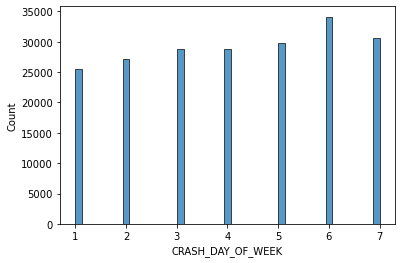

In [54]:
sns.histplot(df["CRASH_DAY_OF_WEEK"]);

Bin with CRASH_HOUR for times of day.

In [55]:
df["PRIM_CONTRIBUTORY_CAUSE"].value_counts(dropna=False)

UNABLE TO DETERMINE                                                                 64971
FAILING TO YIELD RIGHT-OF-WAY                                                       31531
FOLLOWING TOO CLOSELY                                                               23676
FAILING TO REDUCE SPEED TO AVOID CRASH                                              10899
IMPROPER OVERTAKING/PASSING                                                         10896
IMPROPER TURNING/NO SIGNAL                                                           8718
NOT APPLICABLE                                                                       8318
IMPROPER LANE USAGE                                                                  7043
DISREGARDING TRAFFIC SIGNALS                                                         6580
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  6536
IMPROPER BACKING                                                                     5671
WEATHER   

The only possibly useful data point is what can be known demographically before a crash. So DRIVING SKILLS/KNOWLEDGE/EXPERIENCE should be made into a flag.

In [56]:
df["SEC_CONTRIBUTORY_CAUSE"].value_counts(dropna=False)

NOT APPLICABLE                                                                      81684
UNABLE TO DETERMINE                                                                 69212
FAILING TO YIELD RIGHT-OF-WAY                                                        9321
FAILING TO REDUCE SPEED TO AVOID CRASH                                               8310
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  7313
FOLLOWING TOO CLOSELY                                                                6873
IMPROPER OVERTAKING/PASSING                                                          3489
IMPROPER LANE USAGE                                                                  3082
IMPROPER TURNING/NO SIGNAL                                                           3005
WEATHER                                                                              2701
DISREGARDING TRAFFIC SIGNALS                                                         1295
IMPROPER B

DRIVING SKILLS/KNOWLEDGE/EXPERIENCE used with same above for a flag.

## Feature Engineering

### Feature Engineering

Binning in state and out of state without losing the null values. We will impute after Train/Test Split.

In [57]:
states = sorted(df["DRIVERS_LICENSE_STATE"].value_counts().index)
states.remove('IL')

In [58]:
def in_state(row):
    if row['DRIVERS_LICENSE_STATE'] == 'IL':
        return 1
    elif row['DRIVERS_LICENSE_STATE'] in states:
        return 0

df['IN_STATE'] = df.apply(in_state, axis=1)

In [59]:
# Sanity check 

df["IN_STATE"].value_counts(dropna=False)

1.0    184325
0.0     12058
NaN      8663
Name: IN_STATE, dtype: int64

We are interested in driving skills, knowledge, or experience as a contributing cause of accidents.

In [60]:
(df['PRIM_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE').value_counts(normalize=True)

False    0.968124
True     0.031876
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: float64

In [61]:
(df['SEC_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE').value_counts(normalize=True)

False    0.964335
True     0.035665
Name: SEC_CONTRIBUTORY_CAUSE, dtype: float64

In [62]:
((df['PRIM_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE') & (df['SEC_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE')).value_counts(normalize=True)

False    0.994318
True     0.005682
dtype: float64

In [63]:
# Create a new column to identify any contributory cause as "driving skills/knowledge/experience"

def get_cause(row):
    if row['PRIM_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE':
        return 1
    if row['SEC_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE':
        return 1
    else:
        return 0
df['DRIVING_SKILLS'] = df.apply(get_cause, axis=1)
   

In [64]:
df['DRIVING_SKILLS'].value_counts(normalize=True)

0    0.938141
1    0.061859
Name: DRIVING_SKILLS, dtype: float64

In [65]:
df.groupby("DRIVING_SKILLS").DAMAGE.value_counts(normalize=True)

DRIVING_SKILLS  DAMAGE       
0               OVER $1,500      0.718032
                $501 - $1,500    0.212916
                $500 OR LESS     0.069052
1               OVER $1,500      0.734784
                $501 - $1,500    0.190713
                $500 OR LESS     0.074503
Name: DAMAGE, dtype: float64

While DRIVING_SKILLS is a very lopsided value, there is an indication that it affects the DAMAGE. We may be able to SMOTE this for our model.

We want to identify crashes by the time of day they occurred.

In [66]:
# Create a new column to identify the time of day crashes occurred

def hour(row):
    if (row['CRASH_HOUR'] < 7) or (row['CRASH_HOUR'] >23):
        return 'Evening/Overnight'
    elif (row['CRASH_DAY_OF_WEEK'] in range(2,7)) and (row['CRASH_HOUR'] in range(7,10)) or (row['CRASH_HOUR'] in range(16,19)):
        return 'Commute'
    elif row['CRASH_HOUR'] in range(19,24):
        return 'Evening/Overnight'
    else:
        return 'Daytime'
df['TIME_OF_DAY'] = df.apply(hour, axis=1)

In [67]:
df['TIME_OF_DAY'].value_counts(dropna=False, normalize=True)

Daytime              0.382821
Commute              0.348756
Evening/Overnight    0.268423
Name: TIME_OF_DAY, dtype: float64

In [68]:
# Check the values in Damage column

df['DAMAGE'].value_counts()

OVER $1,500      147442
$501 - $1,500     43376
$500 OR LESS      14228
Name: DAMAGE, dtype: int64

In [69]:
# Create a new column to identify damage as > $1500 or <= $1500

damage_dict = {'OVER $1,500':1, '$501 - $1,500':0, '$500 OR LESS':0}
df['DAMAGE_OVER_1500'] =  df.loc[:, ('DAMAGE')].map(damage_dict).copy()

In [70]:
# Sanity check

df['DAMAGE_OVER_1500'].value_counts()

1    147442
0     57604
Name: DAMAGE_OVER_1500, dtype: int64

<AxesSubplot:xlabel='DAMAGE', ylabel='Count'>

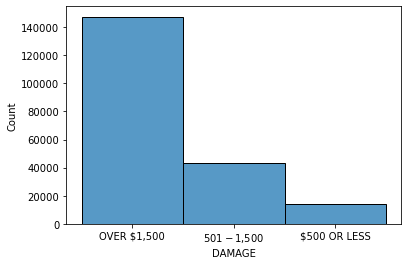

In [71]:
sns.histplot(df["DAMAGE"], )

In [72]:
df["DAMAGE"].value_counts(normalize=True)

OVER $1,500      0.719068
$501 - $1,500    0.211543
$500 OR LESS     0.069389
Name: DAMAGE, dtype: float64

<AxesSubplot:xlabel='DAMAGE_OVER_1500', ylabel='Count'>

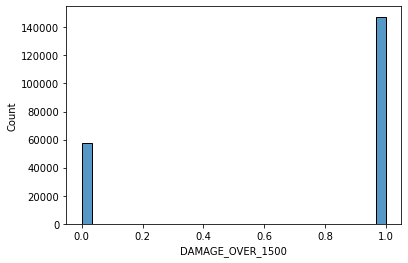

In [73]:
sns.histplot(df["DAMAGE_OVER_1500"])

### Comparing columns to DAMAGE_OVER_1500

In [74]:
df.groupby("AGE").DAMAGE_OVER_1500.value_counts().sort_values(ascending=False)

AGE    DAMAGE_OVER_1500
28.0   1                   4674
25.0   1                   4621
26.0   1                   4577
27.0   1                   4563
29.0   1                   4549
                           ... 
103.0  1                      1
101.0  1                      1
98.0   1                      1
97.0   0                      1
110.0  1                      1
Name: DAMAGE_OVER_1500, Length: 174, dtype: int64

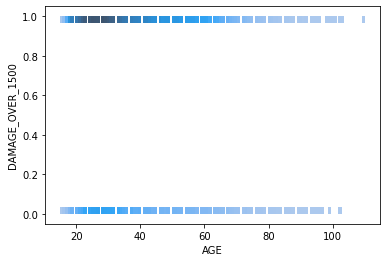

In [75]:
sns.histplot(x=df["AGE"], y=df["DAMAGE_OVER_1500"]);

In [76]:
df.groupby("VEHICLE_YEAR").DAMAGE_OVER_1500.value_counts().sort_values(ascending=False)

VEHICLE_YEAR  DAMAGE_OVER_1500
2017.0        1                   11400
2018.0        1                   10669
2015.0        1                   10197
2016.0        1                    9971
2019.0        1                    9711
2014.0        1                    9208
2020.0        1                    8606
2013.0        1                    8561
2012.0        1                    7433
2021.0        1                    6689
2011.0        1                    6642
2010.0        1                    5877
2007.0        1                    5746
2008.0        1                    5670
2009.0        1                    4698
2017.0        0                    4429
2006.0        1                    4383
2018.0        0                    4123
2016.0        0                    4027
2019.0        0                    4024
2015.0        0                    3988
2005.0        1                    3972
2022.0        1                    3893
2014.0        0                    3669
2020.0   

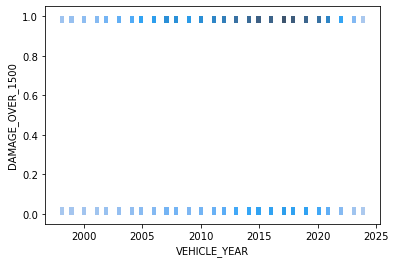

In [77]:
sns.histplot(x=df["VEHICLE_YEAR"], y=df["DAMAGE_OVER_1500"]);

In [78]:
df.groupby("TIME_OF_DAY").DAMAGE_OVER_1500.value_counts(normalize=True)

TIME_OF_DAY        DAMAGE_OVER_1500
Commute            1                   0.704381
                   0                   0.295619
Daytime            1                   0.698329
                   0                   0.301671
Evening/Overnight  1                   0.767728
                   0                   0.232272
Name: DAMAGE_OVER_1500, dtype: float64

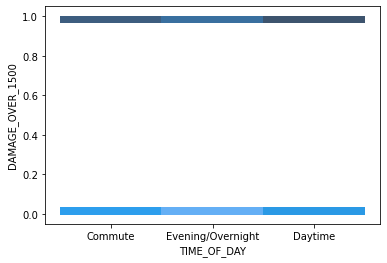

In [79]:
sns.histplot(x=df["TIME_OF_DAY"], y=df["DAMAGE_OVER_1500"]);

In [80]:
df.groupby("SEX").DAMAGE_OVER_1500.value_counts()

SEX  DAMAGE_OVER_1500
F    1                   65791
     0                   26703
M    1                   81514
     0                   30837
X    1                     137
     0                      64
Name: DAMAGE_OVER_1500, dtype: int64

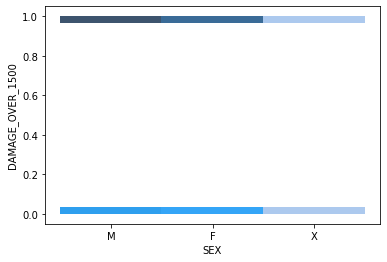

In [81]:
sns.histplot(x=df["SEX"], y=df["DAMAGE_OVER_1500"]);

In [82]:
df.groupby("IN_STATE").DAMAGE_OVER_1500.value_counts()

IN_STATE  DAMAGE_OVER_1500
0.0       1                     8515
          0                     3543
1.0       1                   132443
          0                    51882
Name: DAMAGE_OVER_1500, dtype: int64

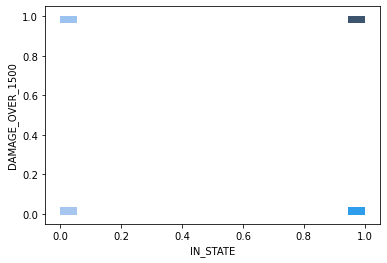

In [83]:
sns.histplot(x=df["IN_STATE"], y=df["DAMAGE_OVER_1500"]);

In [84]:
df.groupby("CRASH_HOUR").DAMAGE_OVER_1500.value_counts()

CRASH_HOUR  DAMAGE_OVER_1500
0           1                    3089
            0                     733
1           1                    2607
            0                     660
2           1                    2258
            0                     501
3           1                    1738
            0                     336
4           1                    1583
            0                     299
5           1                    1904
            0                     490
6           1                    2955
            0                     881
7           1                    6453
            0                    2312
8           1                    7782
            0                    3171
9           1                    6175
            0                    2396
10          1                    6222
            0                    2508
11          1                    7146
            0                    2950
12          1                    8109
            0        

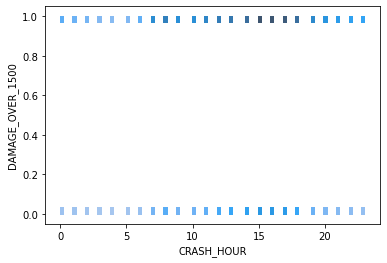

In [85]:
sns.histplot(x=df["CRASH_HOUR"], y=df["DAMAGE_OVER_1500"]);

In [253]:
# Creating new csv file as checkpoint
#df.to_csv("Data\modeltime.csv")
df = pd.read_csv("Data\modeltime.csv", parse_dates=["CRASH_DATE"], low_memory=False)

## Initial Modeling

### Initial Dummy Model

#### Decide Xs/y

The target is DAMAGE_OVER_1500. There are a few columns which represent interrelated variables, so only one will be used. 

In [254]:
X = df.drop(["DAMAGE", "DAMAGE_OVER_1500"], axis=1)
y = df["DAMAGE_OVER_1500"]

#### Train/Test Split

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

#### Modeling 

In [256]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [257]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [258]:
y_pred = dummy_model.predict(X_test)
dummy1_accuracy = accuracy_score(y_test, y_pred)
dummy1_accuracy

0.7170028481136124

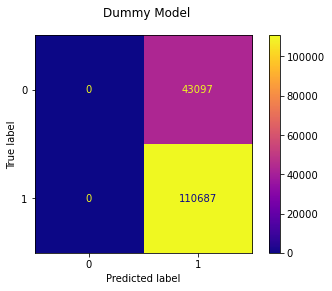

In [259]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

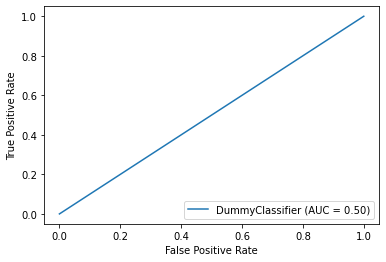

In [260]:
plot_roc_curve(dummy_model, X_train, y_train);

### Initial Decision Tree Classifier

In [261]:
# Making a dataframe numeric columns

df_dt = df[["VEHICLE_YEAR", "SEX", "DRIVING_SKILLS", "TIME_OF_DAY", "DAMAGE_OVER_1500"]]

In [262]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205046 entries, 0 to 205045
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VEHICLE_YEAR      205046 non-null  float64
 1   SEX               205046 non-null  object 
 2   DRIVING_SKILLS    205046 non-null  int64  
 3   TIME_OF_DAY       205046 non-null  object 
 4   DAMAGE_OVER_1500  205046 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.8+ MB


In [263]:
# Assigning Xs & y 

X_dt = df_dt.drop("DAMAGE_OVER_1500", axis=1)
y_dt = df["DAMAGE_OVER_1500"]

#### Train/Test Split

In [264]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, random_state=2024)

#### Preprocessing Steps (SS, OHE, SI)

In [265]:
df_dt.isna().sum()

VEHICLE_YEAR        0
SEX                 0
DRIVING_SKILLS      0
TIME_OF_DAY         0
DAMAGE_OVER_1500    0
dtype: int64

In [266]:
encoding = OneHotEncoder(categories="auto", handle_unknown="ignore")
X_train_dt_imp = encoding.fit_transform(X_train_dt)
X_test_dt_imp = encoding.transform(X_test_dt)

In [267]:
names = pd.DataFrame(X_train_dt_imp.todense(), columns=encoding.get_feature_names())

#### Modeling 

In [268]:
dt = DecisionTreeClassifier(max_depth=2, random_state=2024)
dt.fit(X_train_dt_imp, y_train_dt)

DecisionTreeClassifier(max_depth=2, random_state=2024)

In [269]:
dt.score(X_train_dt_imp, y_train_dt)

0.7197562815377413

In [270]:
dt.score(X_test_dt_imp, y_test_dt)

0.7170028481136124

[Text(167.4, 181.2, 'X[34] <= 0.5\ngini = 0.403\nsamples = 153784\nvalue = [43097, 110687]'),
 Text(83.7, 108.72, 'X[30] <= 0.5\ngini = 0.418\nsamples = 112627\nvalue = [33573, 79054]'),
 Text(41.85, 36.23999999999998, 'gini = 0.394\nsamples = 7171\nvalue = [1934, 5237]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.42\nsamples = 105456\nvalue = [31639, 73817]'),
 Text(251.10000000000002, 108.72, 'X[27] <= 0.5\ngini = 0.356\nsamples = 41157\nvalue = [9524, 31633]'),
 Text(209.25, 36.23999999999998, 'gini = 0.35\nsamples = 24871\nvalue = [5616, 19255]'),
 Text(292.95, 36.23999999999998, 'gini = 0.365\nsamples = 16286\nvalue = [3908, 12378]')]

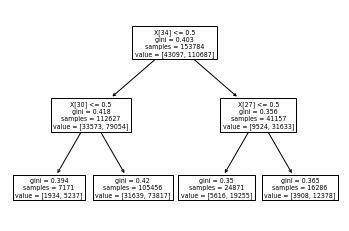

In [271]:
plot_tree(dt, max_depth=2)

In [272]:
names.columns[34]

'x3_Evening/Overnight'

### Initial Logistic Regression with TIME_OF_DAY

#### Decide Xs/y

In [273]:
df_lr = df[["TIME_OF_DAY", "DAMAGE_OVER_1500"]]

In [274]:
X_lr = df_lr.drop("DAMAGE_OVER_1500", axis=1)
y_lr = df_lr["DAMAGE_OVER_1500"]

#### Train/Test Split

In [275]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=2024)

#### Preprocessing Steps (SS, OHE, SI)

In [276]:
X_train_lr_imp = encoding.fit_transform(X_train_lr)
X_test_lr_imp = encoding.transform(X_test_lr)

In [277]:
ss = StandardScaler(with_mean=False)

In [278]:
ss.fit_transform(X_train_lr_imp)
ss.transform(X_test_lr_imp)

<51262x3 sparse matrix of type '<class 'numpy.float64'>'
	with 51262 stored elements in Compressed Sparse Row format>

#### Modeling 

In [279]:
logreg = LogisticRegression(random_state=2024)

In [280]:
logreg.fit(X_train_lr_imp, y_train_lr)
y_pred_lr = logreg.predict(X_test_lr_imp)

In [281]:
logreg.coef_

array([[0.1449216 , 0.11200245, 0.47158043]])

In [282]:
ToD1_accuracy = accuracy_score(y_test_lr, y_pred_lr)
ToD1_accuracy

0.7170028481136124

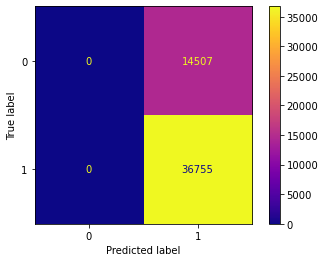

In [283]:
fig, ax = plt.subplots()
plot_confusion_matrix(logreg, X_test_lr_imp, y_test_lr, ax=ax, cmap="plasma");

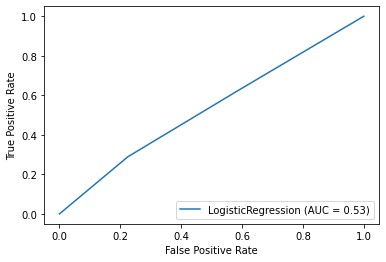

In [284]:
plot_roc_curve(logreg, X_test_lr_imp, y_test_lr);

In [285]:
log_loss(y_test_lr, logreg.predict_proba(X_test_lr_imp))

0.5936086516408869

In [286]:
logreg.intercept_

array([0.72879252])

In [287]:
logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.67454024])

In [288]:
odds

array([2.0725765])

## Evaluation of Initial Models

### Accuracy Scores of Initial Models

In [410]:
print("Baseline Accuracy:          ", round((dummy1_accuracy*100), ndigits=1), "%")
print("Time of Day LogReg Accuracy:", round((ToD1_accuracy*100), ndigits=1), "%")

Baseline Accuracy:           71.7 %
Time of Day LogReg Accuracy: 71.7 %


Decision Tree and Logistic Regression Accuracy scores are the same as the Dummy Model. We will undersample the majority class to see if it runs better.

## Balance Data and Redo Models

### Undersampling Majority to Balance Data

In [290]:
df["DAMAGE_OVER_1500"].value_counts()

1    147442
0     57604
Name: DAMAGE_OVER_1500, dtype: int64

In [291]:
over = df[df["DAMAGE_OVER_1500"]==1]
under = df[df["DAMAGE_OVER_1500"]==0]
over_small = over.sample(n=len(under), random_state=2024)
df = pd.concat([under, over_small],axis=0)

In [292]:
df["DAMAGE_OVER_1500"].value_counts()

1    57604
0    57604
Name: DAMAGE_OVER_1500, dtype: int64

### Dummy Model Redo

#### Decide Xs/y

The target is DAMAGE_OVER_1500. There are a few columns which represent interrelated variables, so only one will be used. 

In [293]:
X = df.drop(["DAMAGE", "DAMAGE_OVER_1500"], axis=1)
y = df["DAMAGE_OVER_1500"]

#### Train/Test Split

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

#### Modeling 

In [295]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [296]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [297]:
y_pred = dummy_model.predict(X_test)
dummy2_accuracy = accuracy_score(y_test, y_pred)
dummy2_accuracy

0.49927088396639124

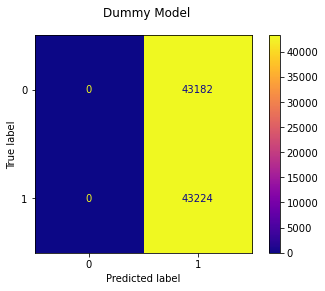

In [298]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

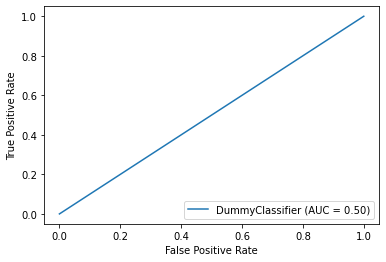

In [299]:
plot_roc_curve(dummy_model, X_train, y_train);

### Decision Tree Classifier Redo

In [300]:
# Making a dataframe from numeric columns

df_dt = df[["VEHICLE_YEAR", "SEX", "DRIVING_SKILLS", "TIME_OF_DAY", "DAMAGE_OVER_1500"]]

In [301]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115208 entries, 9 to 188670
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VEHICLE_YEAR      115208 non-null  float64
 1   SEX               115208 non-null  object 
 2   DRIVING_SKILLS    115208 non-null  int64  
 3   TIME_OF_DAY       115208 non-null  object 
 4   DAMAGE_OVER_1500  115208 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.3+ MB


In [302]:
# Assigning Xs & y 

X_dt = df_dt.drop("DAMAGE_OVER_1500", axis=1)
y_dt = df["DAMAGE_OVER_1500"]

#### Train/Test Split

In [303]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, random_state=2024)

#### Preprocessing Steps (SS, OHE, SI)

In [304]:
df_dt.isna().sum()

VEHICLE_YEAR        0
SEX                 0
DRIVING_SKILLS      0
TIME_OF_DAY         0
DAMAGE_OVER_1500    0
dtype: int64

In [305]:
encoding = OneHotEncoder(categories="auto", handle_unknown="ignore")
X_train_dt_imp = encoding.fit_transform(X_train_dt)
X_test_dt_imp = encoding.transform(X_test_dt)

In [306]:
names = pd.DataFrame(X_train_dt_imp.todense(), columns=encoding.get_feature_names())

#### Modeling 

In [307]:
dt = DecisionTreeClassifier(max_depth=2, random_state=2024)
dt.fit(X_train_dt_imp, y_train_dt)

DecisionTreeClassifier(max_depth=2, random_state=2024)

In [308]:
dt.score(X_train_dt_imp, y_train_dt)

0.5321852649121589

In [309]:
dt.score(X_test_dt_imp, y_test_dt)

0.5318727866120408

[Text(167.4, 181.2, 'X[34] <= 0.5\ngini = 0.5\nsamples = 86406\nvalue = [43182, 43224]'),
 Text(83.7, 108.72, 'X[28] <= 0.5\ngini = 0.499\nsamples = 64344\nvalue = [33552, 30792]'),
 Text(41.85, 36.23999999999998, 'gini = 0.498\nsamples = 30481\nvalue = [16164, 14317]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.5\nsamples = 33863\nvalue = [17388, 16475]'),
 Text(251.10000000000002, 108.72, 'X[9] <= 0.5\ngini = 0.492\nsamples = 22062\nvalue = [9630, 12432]'),
 Text(209.25, 36.23999999999998, 'gini = 0.492\nsamples = 21255\nvalue = [9312, 11943]'),
 Text(292.95, 36.23999999999998, 'gini = 0.478\nsamples = 807\nvalue = [318, 489]')]

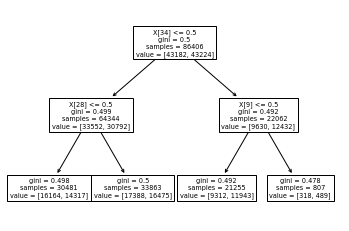

In [310]:
plot_tree(dt, max_depth=2)

In [311]:
names.columns[34]

'x3_Evening/Overnight'

### Logistic Regression with TIME_OF_DAY Redo

#### Decide Xs/y

In [312]:
df_lr = df[["TIME_OF_DAY", "DAMAGE_OVER_1500"]]

In [313]:
X_lr = df_lr.drop("DAMAGE_OVER_1500", axis=1)
y_lr = df_lr["DAMAGE_OVER_1500"]

#### Train/Test Split

In [314]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=2024)

#### Preprocessing Steps (SS, OHE, SI)

In [315]:
X_train_lr_imp = encoding.fit_transform(X_train_lr)
X_test_lr_imp = encoding.transform(X_test_lr)

In [316]:
ss = StandardScaler(with_mean=False)

In [317]:
ss.fit_transform(X_train_lr_imp)
ss.transform(X_test_lr_imp)

<28802x3 sparse matrix of type '<class 'numpy.float64'>'
	with 28802 stored elements in Compressed Sparse Row format>

#### Modeling 

In [318]:
logreg = LogisticRegression(random_state=2024)

In [319]:
logreg.fit(X_train_lr_imp, y_train_lr)
y_pred_lr = logreg.predict(X_test_lr_imp)

In [320]:
logreg.coef_

array([[-0.09528027, -0.11763681,  0.23412888]])

In [321]:
ToD2_accuracy = accuracy_score(y_test_lr, y_pred_lr)
ToD2_accuracy

0.5318727866120408

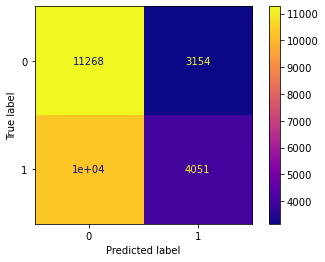

In [322]:
fig, ax = plt.subplots()
plot_confusion_matrix(logreg, X_test_lr_imp, y_test_lr, ax=ax, cmap="plasma");

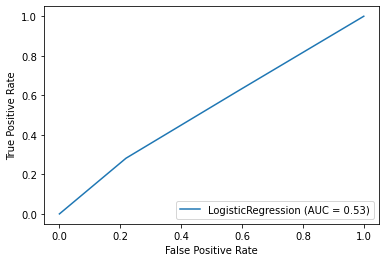

In [323]:
plot_roc_curve(logreg, X_test_lr_imp, y_test_lr);

In [324]:
log_loss(y_test_lr, logreg.predict_proba(X_test_lr_imp))

0.6904965601225233

In [325]:
logreg.intercept_

array([0.02121959])

In [326]:
logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.5053047])

In [327]:
odds

array([1.02144632])

## New Models

### Logistic Regression with TIME_OF_DAY and SEX

#### Decide Xs/y

In [328]:
df_lr2 = df[["TIME_OF_DAY", "SEX", "DAMAGE_OVER_1500"]]

In [329]:
X_lr2 = df_lr2.drop("DAMAGE_OVER_1500", axis=1)
y_lr2 = df_lr2["DAMAGE_OVER_1500"]

#### Train/Test Split

In [330]:
X_train_lr2, X_test_lr2, y_train_lr2, y_test_lr2 = train_test_split(X_lr2, y_lr2, random_state=2024)

#### Preprocessing Steps (SS, OHE, SI)

In [331]:
X_train_lr2_imp = encoding.fit_transform(X_train_lr2)
X_test_lr2_imp = encoding.transform(X_test_lr2)

In [332]:
ss.fit_transform(X_train_lr2_imp)
ss.transform(X_test_lr2_imp)

<28802x6 sparse matrix of type '<class 'numpy.float64'>'
	with 57604 stored elements in Compressed Sparse Row format>

#### Modeling 

In [333]:
logreg.fit(X_train_lr2_imp, y_train_lr2)
y_pred_lr2 = logreg.predict(X_test_lr2_imp)

In [334]:
logreg.coef_

array([[-0.09618739, -0.12025636,  0.22743209, -0.02381611,  0.04327644,
        -0.008472  ]])

In [335]:
TS_accuracy = accuracy_score(y_test_lr2, y_pred_lr2)
TS_accuracy

0.5318727866120408

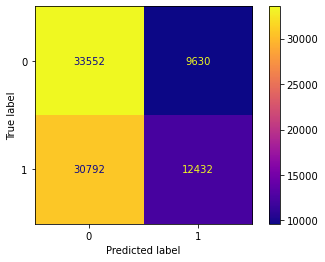

In [336]:
fig, ax = plt.subplots()
plot_confusion_matrix(logreg, X_train_lr2_imp, y_train_lr2, ax=ax, cmap="plasma");

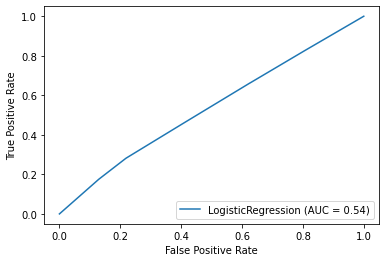

In [337]:
plot_roc_curve(logreg, X_test_lr2_imp, y_test_lr2);

In [338]:
log_loss(y_test_lr2, logreg.predict_proba(X_test_lr2_imp))

0.6903979618094603

In [339]:
logreg.intercept_

array([0.01149027])

In [340]:
logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.50287254])

In [341]:
odds

array([1.01155654])

### Logistic Regression with all Numeric

#### Decide Xs/y

In [342]:
df_lr3 = df_dt

In [343]:
X_lr3 = df_lr3.drop("DAMAGE_OVER_1500", axis=1)
y_lr3 = df_lr3["DAMAGE_OVER_1500"]

#### Train/Test Split

In [344]:
X_train_lr3, X_test_lr3, y_train_lr3, y_test_lr3 = train_test_split(X_lr3, y_lr3, random_state=2024)

#### Preprocessing Steps (SS, OHE, SI)

In [345]:
X_train_lr3_imp = encoding.fit_transform(X_train_lr3)
X_test_lr3_imp = encoding.transform(X_test_lr3)

In [346]:
ss.fit_transform(X_train_lr3_imp)
ss.transform(X_test_lr3_imp)

<28802x35 sparse matrix of type '<class 'numpy.float64'>'
	with 115208 stored elements in Compressed Sparse Row format>

#### Modeling 

In [347]:
logreg = LogisticRegression(random_state=2024, max_iter=1000)

In [348]:
logreg.fit(X_train_lr3_imp, y_train_lr3)
y_pred_lr3 = logreg.predict(X_test_lr3_imp)

In [349]:
num_accuracy = accuracy_score(y_test_lr3, y_pred_lr3)
num_accuracy

0.529442399833345

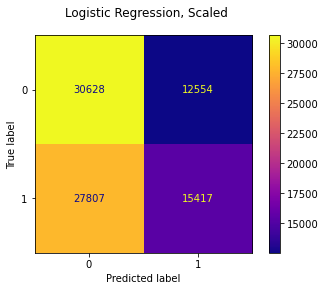

In [350]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression, Scaled")

plot_confusion_matrix(logreg, X_train_lr3_imp, y_train_lr3, ax=ax, cmap="plasma");

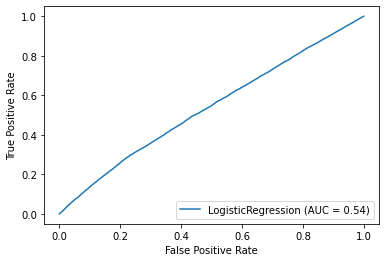

In [351]:
plot_roc_curve(logreg, X_test_lr3_imp, y_test_lr3);

In [352]:
log_loss(y_test_lr3, logreg.predict_proba(X_test_lr3_imp))

0.6903630592165213

In [353]:
logreg.intercept_

array([0.04097366])

In [354]:
logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.51024198])

In [355]:
odds

array([1.04182466])

### Logistic Regression with All Columns

#### Decide Xs/y

In [356]:
dfall = df[["MAKE", "MODEL", "VEHICLE_YEAR", "VEHICLE_TYPE", "OCCUPANT_CNT", "SEX", "AGE", "IN_STATE", "DRIVING_SKILLS", "TIME_OF_DAY", "DAMAGE_OVER_1500"]]

In [357]:
X = dfall.drop("DAMAGE_OVER_1500", axis=1)
y = dfall["DAMAGE_OVER_1500"]

#### Train/Test Split

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

#### Preprocessing Steps (SS, OHE, SI)

##### Null Indicator

In [359]:
X_train.columns

Index(['MAKE', 'MODEL', 'VEHICLE_YEAR', 'VEHICLE_TYPE', 'OCCUPANT_CNT', 'SEX',
       'AGE', 'IN_STATE', 'DRIVING_SKILLS', 'TIME_OF_DAY'],
      dtype='object')

In [360]:
X_train.isna().sum()

MAKE                 0
MODEL                0
VEHICLE_YEAR         0
VEHICLE_TYPE         0
OCCUPANT_CNT         0
SEX                  0
AGE                  0
IN_STATE          3551
DRIVING_SKILLS       0
TIME_OF_DAY          0
dtype: int64

In [361]:
indicator = MissingIndicator(features="all")
indicator.fit(X_train)

MissingIndicator(features='all')

In [362]:
def add_missing_indicator_columns(X, indicator):
    """
    Helper function for transforming features
    
    For every feature in X, create another feature indicating whether that feature
    is missing. (This doubles the number of columns in X.)
    """
    
    # create a 2D array of True and False values indicating whether a given feature
    # is missing for that row
    missing_array_bool = indicator.transform(X)
    
    # transform into 1 and 0 for modeling
    missing_array_int = missing_array_bool.astype(int)
    
    # helpful for readability but not needed for modeling
    missing_column_names = [col + "_missing" for col in X.columns]
    
    # convert to df so it we can concat with X
    missing_df = pd.DataFrame(missing_array_int, columns=missing_column_names, index=X.index)
    
    return pd.concat([X, missing_df], axis=1)

In [363]:
X_train = add_missing_indicator_columns(X=X_train, indicator=indicator)

In [364]:
X_train.head()

,MAKE,MODEL,VEHICLE_YEAR,VEHICLE_TYPE,OCCUPANT_CNT,SEX,AGE,IN_STATE,DRIVING_SKILLS,TIME_OF_DAY,MAKE_missing,MODEL_missing,VEHICLE_YEAR_missing,VEHICLE_TYPE_missing,OCCUPANT_CNT_missing,SEX_missing,AGE_missing,IN_STATE_missing,DRIVING_SKILLS_missing,TIME_OF_DAY_missing
39909,TOYOTA,CAMRY,2016.0,PASSENGER,1.0,M,32.0,1.0,1,Daytime,0,0,0,0,0,0,0,0,0,0
97452,FORD,TAURUS,2002.0,PASSENGER,1.0,F,55.0,1.0,0,Daytime,0,0,0,0,0,0,0,0,0,0
97214,DODGE,RAM 2500 PU,2005.0,PICKUP,1.0,M,25.0,1.0,0,Daytime,0,0,0,0,0,0,0,0,0,0
115612,CHEVROLET,OTHER (EXPLAIN IN NARRATIVE),2013.0,PASSENGER,1.0,M,33.0,0.0,0,Evening/Overnight,0,0,0,0,0,0,0,0,0,0
195262,NISSAN,SENTRA,2012.0,PASSENGER,1.0,F,63.0,1.0,0,Daytime,0,0,0,0,0,0,0,0,0,0


##### Simple Imputer

In [365]:
numeric_feature_names = ["VEHICLE_YEAR", "OCCUPANT_CNT", "AGE"]
categorical_feature_names = ["MAKE", "MODEL", "VEHICLE_TYPE", "SEX", "IN_STATE", "DRIVING_SKILLS", "TIME_OF_DAY"]

X_train_numeric = X_train[numeric_feature_names]
X_train_categorical = X_train[categorical_feature_names]

In [366]:
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [367]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

In [368]:
def impute_missing_values(X, imputer):
    """
    Given a DataFrame and an imputer, use the imputer to fill in all
    missing values in the DataFrame
    """
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [369]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

In [370]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

VEHICLE_YEAR      0
OCCUPANT_CNT      0
AGE               0
MAKE              0
MODEL             0
VEHICLE_TYPE      0
SEX               0
IN_STATE          0
DRIVING_SKILLS    0
TIME_OF_DAY       0
dtype: int64

In [371]:
X_train_imputed.head()

,VEHICLE_YEAR,OCCUPANT_CNT,AGE,MAKE,MODEL,VEHICLE_TYPE,SEX,IN_STATE,DRIVING_SKILLS,TIME_OF_DAY
39909,2016.0,1.0,32.0,TOYOTA,CAMRY,PASSENGER,M,1,1,Daytime
97452,2002.0,1.0,55.0,FORD,TAURUS,PASSENGER,F,1,0,Daytime
97214,2005.0,1.0,25.0,DODGE,RAM 2500 PU,PICKUP,M,1,0,Daytime
115612,2013.0,1.0,33.0,CHEVROLET,OTHER (EXPLAIN IN NARRATIVE),PASSENGER,M,0,0,Evening/Overnight
195262,2012.0,1.0,63.0,NISSAN,SENTRA,PASSENGER,F,1,0,Daytime


In [372]:
X_train = X_train.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_train = pd.concat([X_train_imputed, X_train], axis=1)

In [373]:
X_train.head()

,VEHICLE_YEAR,OCCUPANT_CNT,AGE,MAKE,MODEL,VEHICLE_TYPE,SEX,IN_STATE,DRIVING_SKILLS,TIME_OF_DAY,MAKE_missing,MODEL_missing,VEHICLE_YEAR_missing,VEHICLE_TYPE_missing,OCCUPANT_CNT_missing,SEX_missing,AGE_missing,IN_STATE_missing,DRIVING_SKILLS_missing,TIME_OF_DAY_missing
39909,2016.0,1.0,32.0,TOYOTA,CAMRY,PASSENGER,M,1,1,Daytime,0,0,0,0,0,0,0,0,0,0
97452,2002.0,1.0,55.0,FORD,TAURUS,PASSENGER,F,1,0,Daytime,0,0,0,0,0,0,0,0,0,0
97214,2005.0,1.0,25.0,DODGE,RAM 2500 PU,PICKUP,M,1,0,Daytime,0,0,0,0,0,0,0,0,0,0
115612,2013.0,1.0,33.0,CHEVROLET,OTHER (EXPLAIN IN NARRATIVE),PASSENGER,M,0,0,Evening/Overnight,0,0,0,0,0,0,0,0,0,0
195262,2012.0,1.0,63.0,NISSAN,SENTRA,PASSENGER,F,1,0,Daytime,0,0,0,0,0,0,0,0,0,0


In [374]:
X_train.isna().sum()

VEHICLE_YEAR              0
OCCUPANT_CNT              0
AGE                       0
MAKE                      0
MODEL                     0
VEHICLE_TYPE              0
SEX                       0
IN_STATE                  0
DRIVING_SKILLS            0
TIME_OF_DAY               0
MAKE_missing              0
MODEL_missing             0
VEHICLE_YEAR_missing      0
VEHICLE_TYPE_missing      0
OCCUPANT_CNT_missing      0
SEX_missing               0
AGE_missing               0
IN_STATE_missing          0
DRIVING_SKILLS_missing    0
TIME_OF_DAY_missing       0
dtype: int64

##### OHE

In [375]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [376]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [377]:
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [378]:
encoders

{'MAKE': OneHotEncoder(handle_unknown='ignore'),
 'MODEL': OneHotEncoder(handle_unknown='ignore'),
 'VEHICLE_TYPE': OneHotEncoder(handle_unknown='ignore'),
 'SEX': OneHotEncoder(handle_unknown='ignore'),
 'IN_STATE': OneHotEncoder(handle_unknown='ignore'),
 'DRIVING_SKILLS': OneHotEncoder(handle_unknown='ignore'),
 'TIME_OF_DAY': OneHotEncoder(handle_unknown='ignore')}

In [379]:
X_train.head()

,VEHICLE_YEAR,OCCUPANT_CNT,AGE,MAKE_missing,MODEL_missing,VEHICLE_YEAR_missing,VEHICLE_TYPE_missing,OCCUPANT_CNT_missing,SEX_missing,AGE_missing,...,F,M,X,0.0,1.0,0,1,Commute,Daytime,Evening/Overnight
39909,2016.0,1.0,32.0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
97452,2002.0,1.0,55.0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
97214,2005.0,1.0,25.0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
115612,2013.0,1.0,33.0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
195262,2012.0,1.0,63.0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [380]:
X_train.shape

(86406, 354)

##### Standard Scale

In [381]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [382]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [383]:
X_train = scale_values(X_train, scaler)

In [384]:
X_train.head()

,VEHICLE_YEAR,OCCUPANT_CNT,AGE,MAKE_missing,MODEL_missing,VEHICLE_YEAR_missing,VEHICLE_TYPE_missing,OCCUPANT_CNT_missing,SEX_missing,AGE_missing,...,F,M,X,0.0,1.0,0,1,Commute,Daytime,Evening/Overnight
39909,0.445758,-0.417287,-0.507007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.908651,0.910435,-0.031195,-0.252610,0.252610,-3.909158,3.909158,-0.739106,1.246070,-0.585004
97452,-2.022020,-0.417287,0.960697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.100533,-1.098376,-0.031195,-0.252610,0.252610,0.255810,-0.255810,-0.739106,1.246070,-0.585004
97214,-1.493210,-0.417287,-0.953699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.908651,0.910435,-0.031195,-0.252610,0.252610,0.255810,-0.255810,-0.739106,1.246070,-0.585004
115612,-0.083051,-0.417287,-0.443193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.908651,0.910435,-0.031195,3.958666,-3.958666,0.255810,-0.255810,-0.739106,-0.802523,1.709391
195262,-0.259321,-0.417287,1.471203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.100533,-1.098376,-0.031195,-0.252610,0.252610,0.255810,-0.255810,-0.739106,1.246070,-0.585004


#### Model

In [385]:
logreg_model = LogisticRegression(random_state=2024)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=2024)

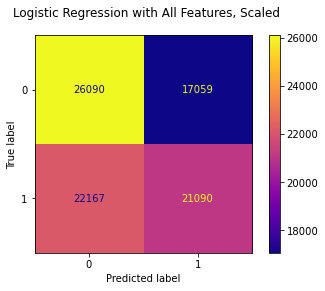

In [386]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features, Scaled")

plot_confusion_matrix(logreg_model, X_train, y_train, ax=ax, cmap="plasma");

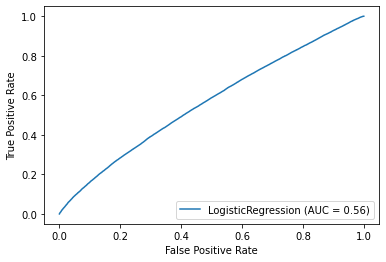

In [387]:
plot_roc_curve(logreg_model, X_train, y_train)

#### Test Evaluation 

Now that we have a final model, run X_test through all of the preprocessing steps so we can evaluate the model's performance

In [388]:
X_test_no_transformations = X_test.copy()

In [389]:
# add missing indicators
X_test_mi = add_missing_indicator_columns(X_test_no_transformations, indicator)

In [390]:
# separate out values for imputation
X_test_numeric = X_test_mi[numeric_feature_names]
X_test_categorical = X_test_mi[categorical_feature_names]

In [391]:
# impute missing values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_imputed = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test_new = X_test_mi.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_test_final = pd.concat([X_test_imputed, X_test_new], axis=1)

In [392]:
# one-hot encode categorical data
for categorical_feature in categorical_feature_names:
    X_test_final = encode_and_concat_feature(X_test_final,
                                       categorical_feature, encoders[categorical_feature])

In [393]:
# scale values
X_test_scaled = scale_values(X_test_final, scaler)

In [394]:
X_test_scaled.head()

,VEHICLE_YEAR,OCCUPANT_CNT,AGE,MAKE_missing,MODEL_missing,VEHICLE_YEAR_missing,VEHICLE_TYPE_missing,OCCUPANT_CNT_missing,SEX_missing,AGE_missing,...,F,M,X,0.0,1.0,0,1,Commute,Daytime,Evening/Overnight
65033,-0.259321,-0.417287,-0.443193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.100533,-1.098376,-0.031195,-0.252610,0.252610,0.255810,-0.255810,-0.739106,1.246070,-0.585004
81052,-1.316940,2.552492,-0.762259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.100533,-1.098376,-0.031195,-0.252610,0.252610,0.255810,-0.255810,-0.739106,-0.802523,1.709391
4401,-0.435591,-0.417287,-0.826073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.908651,0.910435,-0.031195,-0.252610,0.252610,-3.909158,3.909158,-0.739106,-0.802523,1.709391
107181,-0.611861,-0.417287,1.726456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.100533,-1.098376,-0.031195,-0.252610,0.252610,0.255810,-0.255810,-0.739106,-0.802523,1.709391
63026,0.974568,-0.417287,-1.081326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.908651,0.910435,-0.031195,3.958666,-3.958666,0.255810,-0.255810,1.352986,-0.802523,-0.585004


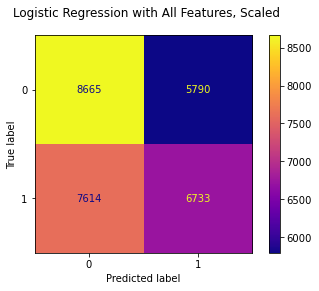

In [395]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features, Scaled")

plot_confusion_matrix(logreg_model, X_test_scaled, y_test, ax=ax, cmap="plasma");

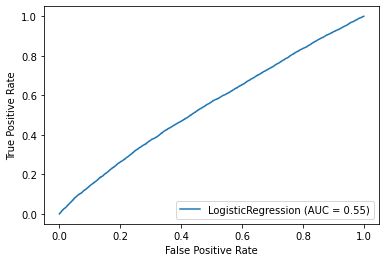

In [396]:
plot_roc_curve(logreg_model, X_test_scaled, y_test)

In [397]:
all_accuracy = accuracy_score(y_test, logreg_model.predict(X_test_scaled))
all_accuracy

0.5346156516908548

In [398]:
log_loss(y_test, logreg_model.predict_proba(X_test_scaled))

0.6948720542673595

In [399]:
logreg.intercept_

array([0.04097366])

In [400]:
logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.51024198])

In [401]:
odds

array([1.04182466])

## Final Model Evaluations 

### Accuracy Score of New Models

In [409]:
print("Baseline Accuracy:                  ", round((dummy2_accuracy*100), ndigits=1), "%")
print("Time of Day LogReg Accuracy:        ", round((ToD2_accuracy*100), ndigits=1), "%")
print("Time of Day and Sex LogReg Accuracy:", round((TS_accuracy*100), ndigits=1), "%")
print("Numeric Columns LogReg Accuracy:    ", round((num_accuracy*100), ndigits=1), "%")
print("All Columns LogReg Accuracy:        ", round((all_accuracy*100), ndigits=1), "%")

Baseline Accuracy:                   49.9 %
Time of Day LogReg Accuracy:         53.2 %
Time of Day and Sex LogReg Accuracy: 53.2 %
Numeric Columns LogReg Accuracy:     52.9 %
All Columns LogReg Accuracy:         53.5 %


### Assessment

After balancing the data, the accuracy score of the Logistic Regression Model using only TIME_OF_DAY improved a small amount over baseline. Adding more columns to our model allowed it to improve marginally above that. Based on our business problem, we cannot say with a great amount of accuracy whether a crash will be above $1500 in damage using only this data. However, we can see that the variable that most influences that outcome is TIME_OF_DAY. When we simply look at TIME_OF_DAY and DAMAGE_OVER_$1500, we can see that ccidents in the evening and overnight are about 8% more likely to cause damage over 1500, compared to other times of day.

In [403]:
df.groupby("TIME_OF_DAY").DAMAGE_OVER_1500.value_counts(normalize=True)

TIME_OF_DAY        DAMAGE_OVER_1500
Commute            0                   0.518990
                   1                   0.481010
Daytime            0                   0.523801
                   1                   0.476199
Evening/Overnight  1                   0.563194
                   0                   0.436806
Name: DAMAGE_OVER_1500, dtype: float64